# Stark shift for SrF molecule

In [1]:
import numpy as np
from numpy.linalg import eigh
import matplotlib.pyplot as plt
import pandas
import sys, os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from diatomic import hyperfine_hamiltonian_no_field, Stark_dc_hamiltonian, SrFConstants, calc_electric_dipole_moment, sort_eigenstates

## DC Stark shift

### Small electric field

@ 0.500 kV/cm
Energy shift (N = 1, F = 1) = -3.665 MHz
Energy shift (N = 1, F = 1) = 6.745 MHz
Energy shift (N = 1, F = 1) = -3.665 MHz
Energy shift (N = 1, F = 0) = -0.398 MHz
Energy shift (N = 1, F = 1) = -1.585 MHz
Energy shift (N = 1, F = 1) = -0.085 MHz
Energy shift (N = 1, F = 1) = -0.085 MHz
Energy shift (N = 1, F = 2) = 5.567 MHz
Energy shift (N = 1, F = 2) = 3.731 MHz
Energy shift (N = 1, F = 2) = 3.731 MHz
Energy shift (N = 1, F = 2) = -5.173 MHz
Energy shift (N = 1, F = 2) = -5.173 MHz


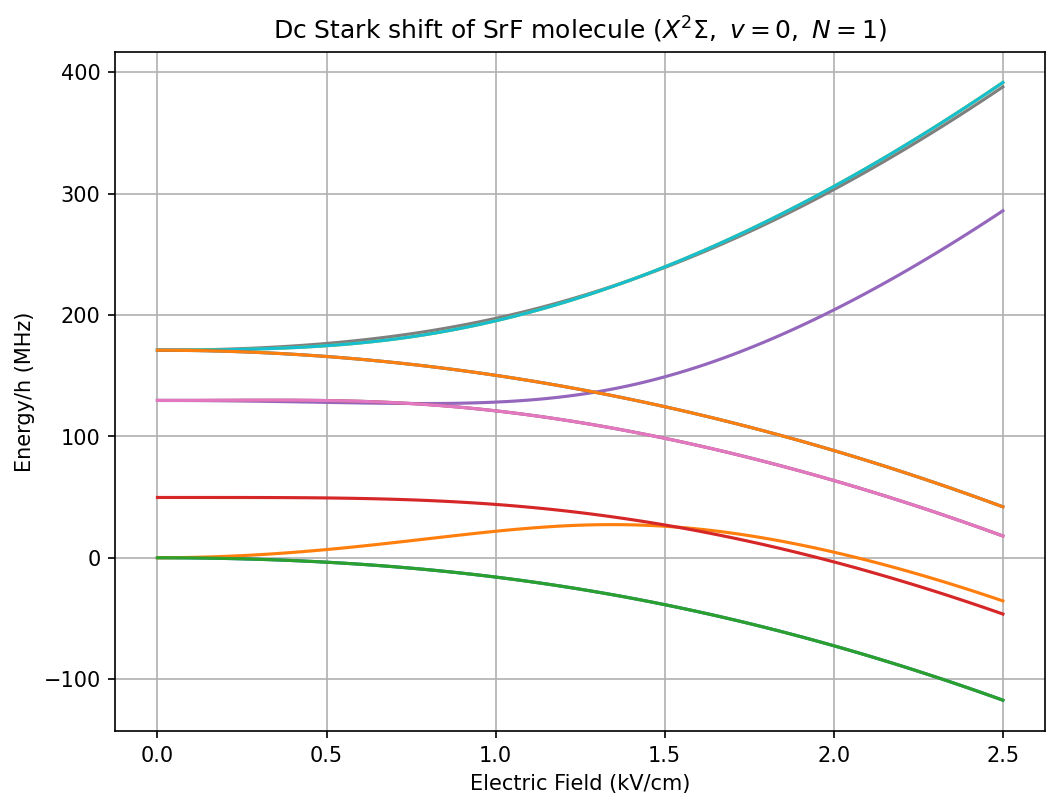

In [69]:
Nmax = 6 # Electric field mixes rotational levels, so we need to include up to sufficiently high Nmax to converge the result
H0 = hyperfine_hamiltonian_no_field(Nmax, SrFConstants) # generate field-free hamiltonian
Hdc = Stark_dc_hamiltonian(Nmax, SrFConstants, Efield=np.array([0, 0, 1])) # generate dc Stark hamiltonian for unit electric field

Ez_list = np.linspace(0, 2.5, 100)
energies_list = np.empty((len(Ez_list), H0.shape[0]), dtype=np.complex_)
states_list = np.empty((len(Ez_list), H0.shape[0], H0.shape[0]), dtype=np.complex_)
for i, Ez in enumerate(Ez_list):
    H = H0 + Hdc * Ez
    energies, states = eigh(H)
    energies_list[i] = energies/1e6
    states_list[i] = states

energies_list, states_list = sort_eigenstates(energies_list, states_list)

E_field = 0.5 # kV/cm
assert E_field >= Ez_list[0] and E_field <= Ez_list[-1] # assert E_field is within range of Ez_list
F_list = [1]*3 + [0] + [1]*3 + [2]*5 # F quantm number for each state
N_list = [1]*12 # N quantm number for each state
print("@ {:.3f} kV/cm".format(E_field))
for i in range(4, 16):
    shift = np.interp(E_field, Ez_list, energies_list[:, i])
    shift -= energies_list[0, i]
    print("Energy shift (N = {:d}, F = {:d}) = {:.3f} MHz".format(N_list[i-4], F_list[i-4], np.real(shift)))

plt.figure(figsize=(8, 6), dpi=150)
plt.plot(Ez_list, np.real(energies_list[:, 4:16]-energies_list[0, 4])) # plot N=1 states w/ offset removed

plt.ylabel("Energy/h (MHz)")
plt.xlabel("Electric Field (kV/cm)")
plt.title("Dc Stark shift of SrF molecule ($X^2\Sigma,\ v=0,\ N=1$)")
plt.grid()
plt.show()


@ 0.500 kV/cm
Energy shift (N = 0, F = 0) = -17.232 MHz
Energy shift (N = 0, F = 1) = -17.228 MHz
Energy shift (N = 0, F = 1) = -17.239 MHz
Energy shift (N = 0, F = 1) = -17.228 MHz


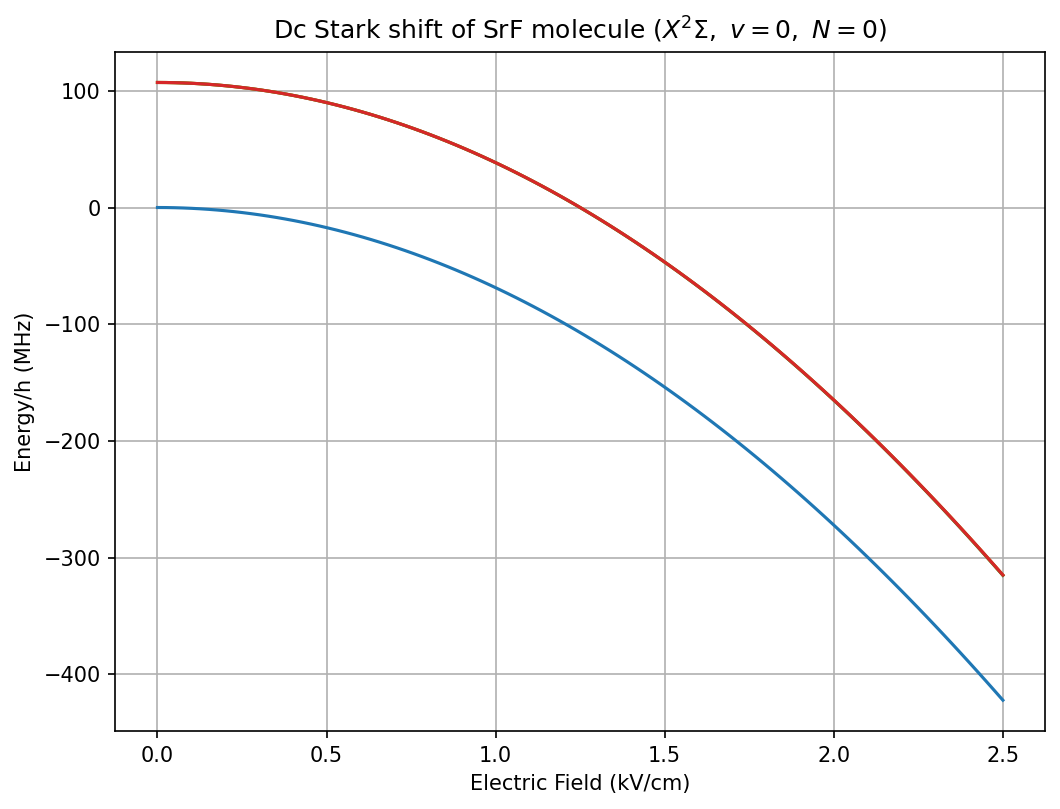

In [68]:
Nmax = 6 # Electric field mixes rotational levels, so we need to include up to sufficiently high Nmax to converge the result
H0 = hyperfine_hamiltonian_no_field(Nmax, SrFConstants) # generate field-free hamiltonian
Hdc = Stark_dc_hamiltonian(Nmax, SrFConstants, Efield=np.array([0, 0, 1])) # generate dc Stark hamiltonian for unit electric field

Ez_list = np.linspace(0, 2.5, 100)
energies_list = np.empty((len(Ez_list), H0.shape[0]), dtype=np.complex_)
states_list = np.empty((len(Ez_list), H0.shape[0], H0.shape[0]), dtype=np.complex_)
for i, Ez in enumerate(Ez_list):
    H = H0 + Hdc * Ez
    energies, states = eigh(H)
    energies_list[i] = energies/1e6
    states_list[i] = states

energies_list, states_list = sort_eigenstates(energies_list, states_list)

E_field = 0.5 # kV/cm
assert E_field >= Ez_list[0] and E_field <= Ez_list[-1] # assert E_field is within range of Ez_list
F_list = [0] + [1]*3 # F quantm number for each state
N_list = [0]*4 # N quantm number for each state
print("@ {:.3f} kV/cm".format(E_field))
for i in range(4):
    shift = np.interp(E_field, Ez_list, energies_list[:, i])
    shift -= energies_list[0, i]
    print("Energy shift (N = {:d}, F = {:d}) = {:.3f} MHz".format(N_list[i], F_list[i], np.real(shift)))

plt.figure(figsize=(8, 6), dpi=150)
plt.plot(Ez_list, np.real(energies_list[:, 0:4]-energies_list[0, 0])) # plot N=1 states w/ offset removed

plt.ylabel("Energy/h (MHz)")
plt.xlabel("Electric Field (kV/cm)")
plt.title("Dc Stark shift of SrF molecule ($X^2\Sigma,\ v=0,\ N=0$)")
plt.grid()
plt.show()


### Up to large electric field

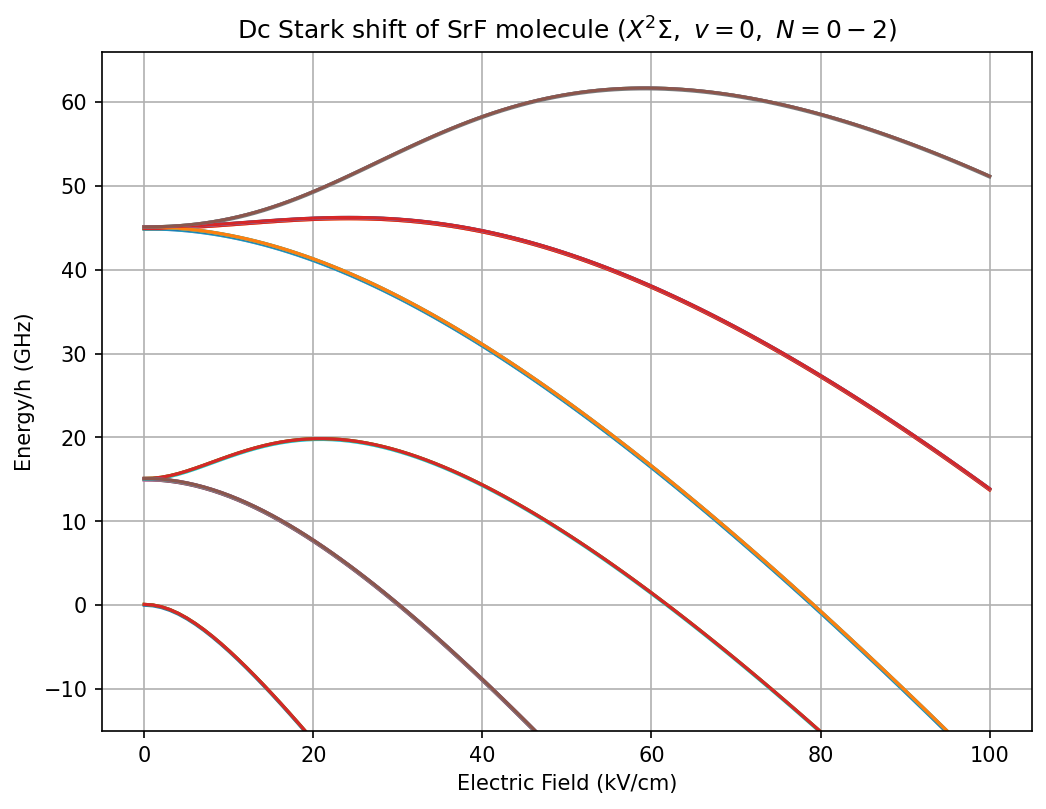

In [3]:
Nmax = 8 # Electric field mixes rotational levels, so we need to include up to sufficiently high Nmax to converge the result
H0 = hyperfine_hamiltonian_no_field(Nmax, SrFConstants) # generate field-free hamiltonian
Hdc = Stark_dc_hamiltonian(Nmax, SrFConstants, Efield=np.array([0, 0, 1])) # generate dc Stark hamiltonian for unit electric field

Ez_list = np.linspace(0, 100, 100)
energies_list = np.empty((len(Ez_list), H0.shape[0]), dtype=np.complex_)
states_list = np.empty((len(Ez_list), H0.shape[0], H0.shape[0]), dtype=np.complex_)
for i, Ez in enumerate(Ez_list):
    H = H0 + Hdc * Ez
    energies, states = eigh(H)
    energies_list[i] = energies/1e9
    states_list[i] = states

energies_list, states_list = sort_eigenstates(energies_list, states_list)

plt.figure(figsize=(8, 6), dpi=150)
plt.plot(Ez_list, np.real(energies_list[:, 0:36]-energies_list[0][0])) # plot up to N=2 states w/ offset removed
plt.ylim(-15, 66)

plt.ylabel("Energy/h (GHz)")
plt.xlabel("Electric Field (kV/cm)")
plt.title("Dc Stark shift of SrF molecule ($X^2\Sigma,\ v=0,\ N=0-2$)")
plt.grid()
plt.show()


### Compared to J. Mol. Spectrosc. 300 (2014) 22-25

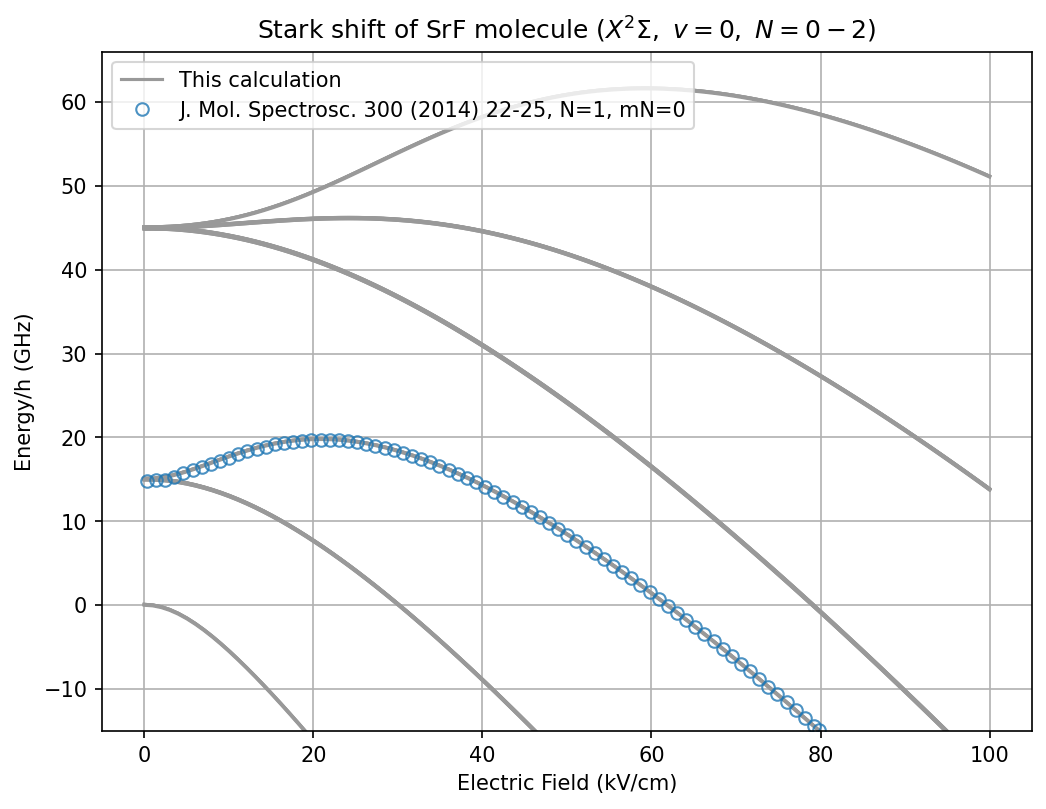

In [4]:
Nmax = 8
H0 = hyperfine_hamiltonian_no_field(Nmax, SrFConstants) # generate field-free hamiltonian
Hdc = Stark_dc_hamiltonian(Nmax, SrFConstants, Efield=np.array([0, 0, 1])) # generate dc Stark hamiltonian for unit electric field

Ez_list = np.linspace(0, 100, 100)
energies_list = np.empty((len(Ez_list), H0.shape[0]), dtype=np.complex_)
states_list = np.empty((len(Ez_list), H0.shape[0], H0.shape[0]), dtype=np.complex_)
for i, Ez in enumerate(Ez_list):
    H = H0 + Hdc * Ez
    energies, states = eigh(H)
    energies_list[i] = energies/1e9
    states_list[i] = states

energies_list, states_list = sort_eigenstates(energies_list, states_list)

df = pandas.read_csv('JMS300(2014)22-25Fig1DataForStarkShift.csv') # data from J. Mol. Spectrosc. 300 (2014) 22-25, Fig 1
df['Energy (cm-1)'] -= df['Energy (cm-1)'][0] # remove energy offset
literature_energy_GHz = df['Energy (cm-1)'] * 29.9792458 # convert to GHz
literature_energy_GHz += np.real(energies_list[0][4]) # add energy offset

fig = plt.figure(figsize=(8, 6), dpi=150)
ax = fig.add_subplot(1,1,1)
ax.plot(Ez_list, np.real(energies_list[:, 0:36]-energies_list[0][0]), color ='#999999', label='This calculation')
ax.plot(df['E field (kV/cm)'], literature_energy_GHz, 'o', markerfacecolor='none', alpha=0.8, label="J. Mol. Spectrosc. 300 (2014) 22-25, N=1, mN=0")
ax.set_ylim(-15, 66)

handles, labels = ax.get_legend_handles_labels()
display = (0,36)

ax.set_ylabel("Energy/h (GHz)")
ax.set_xlabel("Electric Field (kV/cm)")
ax.set_title("Stark shift of SrF molecule ($X^2\Sigma,\ v=0,\ N=0-2$)")
ax.legend([handle for i,handle in enumerate(handles) if i in display],
            [label for i,label in enumerate(labels) if i in display], loc='upper left')
plt.grid()
plt.show()

## Induced lab-frame electric dipole moment

### Small electric field

@ 0.500 kV/cm
Induced dipole moment (N = 0, F = 0) = 0.137 Debye
Induced dipole moment (N = 0, F = 1) = 0.137 Debye
Induced dipole moment (N = 0, F = 1) = 0.137 Debye
Induced dipole moment (N = 0, F = 1) = 0.137 Debye

Induced dipole moment (N = 1, F = 1) = 0.030 Debye
Induced dipole moment (N = 1, F = 1) = -0.051 Debye
Induced dipole moment (N = 1, F = 1) = 0.030 Debye
Induced dipole moment (N = 1, F = 0) = 0.006 Debye
Induced dipole moment (N = 1, F = 1) = 0.010 Debye
Induced dipole moment (N = 1, F = 1) = 0.008 Debye
Induced dipole moment (N = 1, F = 1) = 0.008 Debye
Induced dipole moment (N = 1, F = 2) = -0.047 Debye
Induced dipole moment (N = 1, F = 2) = -0.038 Debye
Induced dipole moment (N = 1, F = 2) = -0.038 Debye
Induced dipole moment (N = 1, F = 2) = 0.041 Debye
Induced dipole moment (N = 1, F = 2) = 0.041 Debye


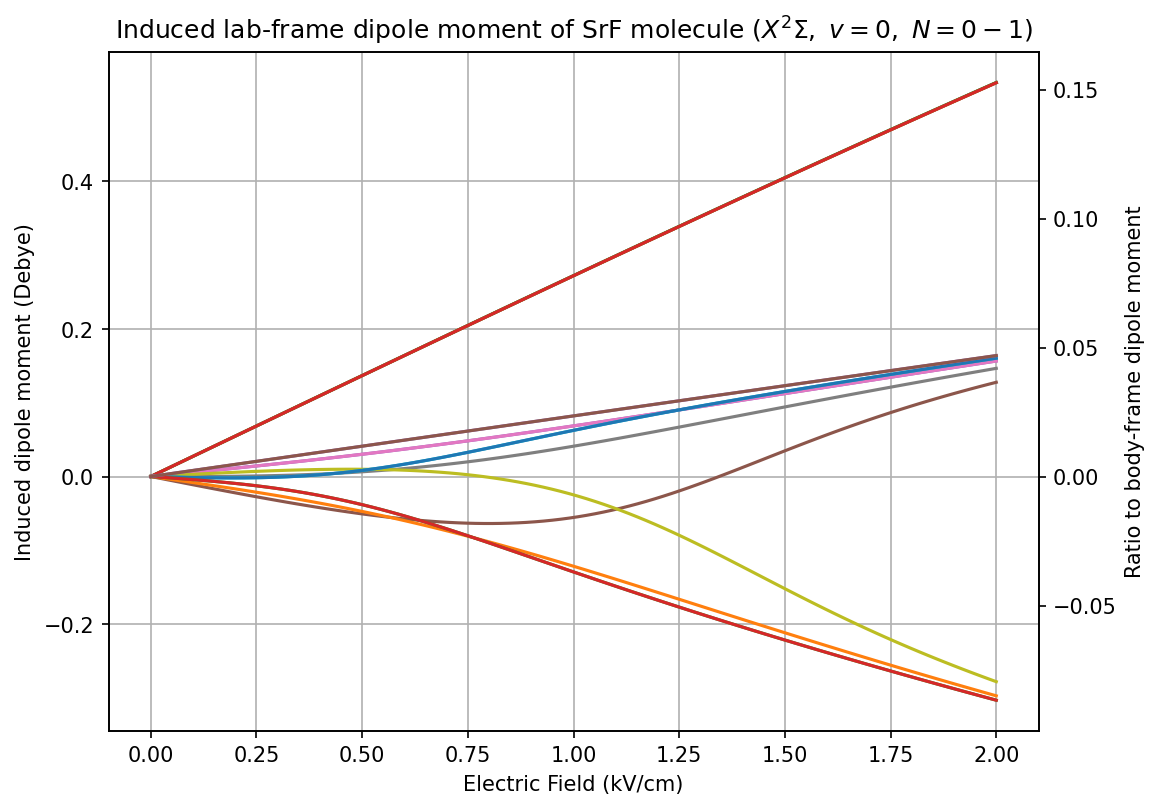

In [66]:
Nmax = 6 # Electric field mixes rotational levels, so we need to include up to sufficiently high Nmax to converge the result
H0 = hyperfine_hamiltonian_no_field(Nmax, SrFConstants) # generate field-free hamiltonian
Hdc = Stark_dc_hamiltonian(Nmax, SrFConstants, Efield=np.array([0, 0, 1])) # generate dc Stark hamiltonian for unit electric field

Ez_list = np.linspace(0, 2, 100)
energies_list = np.empty((len(Ez_list), H0.shape[0]), dtype=np.complex_)
states_list = np.empty((len(Ez_list), H0.shape[0], H0.shape[0]), dtype=np.complex_)
for i, Ez in enumerate(Ez_list):
    H = H0 + Hdc * Ez
    energies, states = eigh(H)
    energies_list[i] = energies/1e6
    states_list[i] = states

energies_list, states_list = sort_eigenstates(energies_list, states_list)
states_list = states_list[:, :, 0:16] # only keep up to N=1 states
dipole_moment_list = calc_electric_dipole_moment(Nmax=Nmax, states=np.hstack(states_list), consts=SrFConstants) # calc_electric_dipole_moment only takes 2D array for argument states
dipole_moment_list = dipole_moment_list[:, 2] # z component only
dipole_moment_list = dipole_moment_list.reshape((-1, states_list.shape[2]))

E_field = 0.5 # kV/cm
assert E_field >= Ez_list[0] and E_field <= Ez_list[-1] # assert E_field is within range of Ez_list
F_list = [0] + [1]*3 + [1]*3 + [0] + [1]*3 + [2]*5 # F quantm number for each state
N_list = [0]*4 + [1]*12 # N quantm number for each state
print("@ {:.3f} kV/cm".format(E_field))
for i in range(16):
    dip = np.interp(E_field, Ez_list, dipole_moment_list[:, i])

    if i == 4:
        print()
    print("Induced dipole moment (N = {:d}, F = {:d}) = {:.3f} Debye".format(N_list[i], F_list[i], dip))

fig = plt.figure(figsize=(8, 6), dpi=150)
ax1 = fig.add_subplot(1,1,1)
ax1.plot(Ez_list, dipole_moment_list) # plot up to N=1 states

ax1.set_ylabel("Induced dipole moment (Debye)")
ax1.set_xlabel("Electric Field (kV/cm)")
ax1.set_title("Induced lab-frame dipole moment of SrF molecule ($X^2\Sigma,\ v=0,\ N=0-1$)")
ax1.grid(True)

ax2 = ax1.twinx()
ymin, ymax = ax1.get_ylim()
ax2.set_ylim(ymin/SrFConstants.DipoleMoment_d, ymax/SrFConstants.DipoleMoment_d)
ax2.set_ylabel('Ratio to body-frame dipole moment')

plt.show()

### Up to large electric field

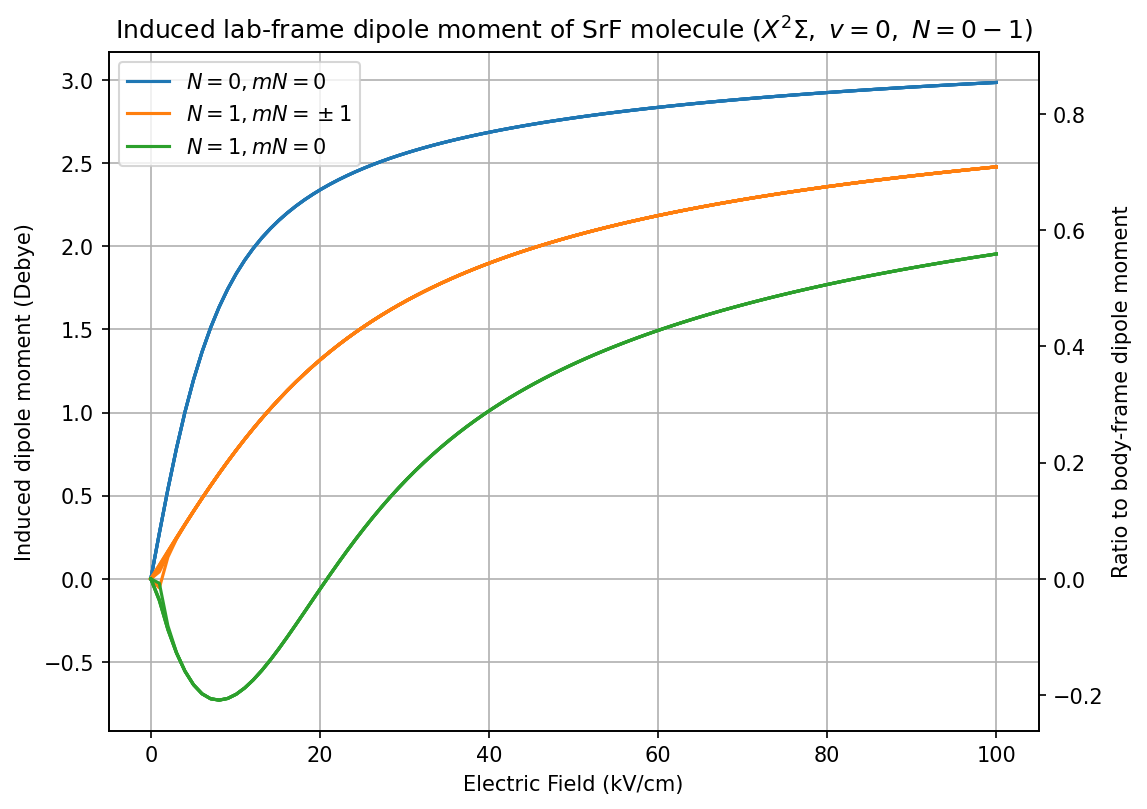

In [6]:
Nmax = 6 # Electric field mixes rotational levels, so we need to include up to sufficiently high Nmax to converge the result
H0 = hyperfine_hamiltonian_no_field(Nmax, SrFConstants) # generate field-free hamiltonian
Hdc = Stark_dc_hamiltonian(Nmax, SrFConstants, Efield=np.array([0, 0, 1])) # generate dc Stark hamiltonian for unit electric field

Ez_list = np.linspace(0, 100, 100)
energies_list = np.empty((len(Ez_list), H0.shape[0]), dtype=np.complex_)
states_list = np.empty((len(Ez_list), H0.shape[0], H0.shape[0]), dtype=np.complex_)
for i, Ez in enumerate(Ez_list):
    H = H0 + Hdc * Ez
    energies, states = eigh(H)
    energies_list[i] = energies
    states_list[i] = states

energies_list, states_list = sort_eigenstates(energies_list, states_list)
states_list = states_list[:, :, 0:16] # only keep up to N=2 states
dipole_moment_list = calc_electric_dipole_moment(Nmax=Nmax, states=np.hstack(states_list), consts=SrFConstants) # calc_electric_dipole_moment only takes 2D array for argument states
dipole_moment_list = dipole_moment_list[:, 2] # z component only
dipole_moment_list = dipole_moment_list.reshape((-1, states_list.shape[2]))

index = energies_list[Ez_list.argmax(), :].argsort() # sort by energy in large field

fig = plt.figure(figsize=(8, 6), dpi=150)
ax1 = fig.add_subplot(1,1,1)
ax1.plot(Ez_list, dipole_moment_list[:, index[0:4]], color="C0", label="$N=0, mN=0$")
ax1.plot(Ez_list, dipole_moment_list[:, index[4:12]], color="C1", label="$N=1, mN=\pm1$")
ax1.plot(Ez_list, dipole_moment_list[:, index[12:16]], color="C2", label="$N=1, mN=0$")

handles, labels = ax1.get_legend_handles_labels()
display = (0,4,12)

ax1.set_ylabel("Induced dipole moment (Debye)")
ax1.set_xlabel("Electric Field (kV/cm)")
ax1.set_title("Induced lab-frame dipole moment of SrF molecule ($X^2\Sigma,\ v=0,\ N=0-1$)")
ax1.grid(True)
ax1.legend([handle for i,handle in enumerate(handles) if i in display],
            [label for i,label in enumerate(labels) if i in display], loc='upper left')

ax2 = ax1.twinx()
ymin, ymax = ax1.get_ylim()
ax2.set_ylim(ymin/SrFConstants.DipoleMoment_d, ymax/SrFConstants.DipoleMoment_d)
ax2.set_ylabel('Ratio to body-frame dipole moment')

plt.show()

## Convergence test

Remain to be done, test convergence vs Nmax